In [83]:
%matplotlib inline
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle
import pandas as pd
import sys
sys.path.insert(0, "../SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.PSF import PSF_generator
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from SyMBac.renderer import convolve_rescale
from tqdm.auto import tqdm
from skimage import color, data, restoration
from matplotlib.colors import LogNorm
from joblib import Parallel, delayed

import matplotlib
matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True

In [2]:
pix_mic_conv = 0.065 / 15
resize_amount = 1

In [3]:
cell_length = 3 #micron
cell_width = 1.01999 #micron
raster_cell_length = cell_length / pix_mic_conv
raster_cell_width = cell_width / pix_mic_conv
def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount = False):


    membrane_thickness = 0.1 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation=0)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, separation=0)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [4]:
raster_cell_width

235.3823076923077

In [5]:
membrane_cell = np.pad(raster_membrane_cell_3d(raster_cell_length,raster_cell_width), ((1,1),(50,50),(50,50)))
print(membrane_cell.shape)

(236, 792, 336)


In [6]:
conv = tifffile.imread("../single_cell_projection_diffraction/targeted_simulation_output/1.0199999999999998_iPSF_ePSF_darkred.tiff")

In [7]:
PSF_darkred = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_darkred.tif")[70:-70,80:-80,80:-80]
PSF_green = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif")[70:-70,80:-80,80:-80]
PSF_orange = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_orange.tif")[70:-70,80:-80,80:-80]

In [8]:
def prepare_ePSF(ePSF, pix_size_original_z, pix_size_original_xy, pix_size_new):
    ePSF = rescale(ePSF, (pix_size_original_z/pix_size_new, pix_size_original_xy / pix_size_new, pix_size_original_xy / pix_size_new), anti_aliasing=True)
    ePSF = ePSF - ePSF.min(axis=(1, 2))[:, np.newaxis, np.newaxis]
    return ePSF

real_PSFs = {
    "ePSF_darkred" : prepare_ePSF(PSF_darkred, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv),
    "ePSF_green" : prepare_ePSF(PSF_green, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv)
}

/tmp/ipykernel_1012577/2073476948.py:5: RuntimeWarning: invalid value encountered in divide
  profile = profile/profile.max()


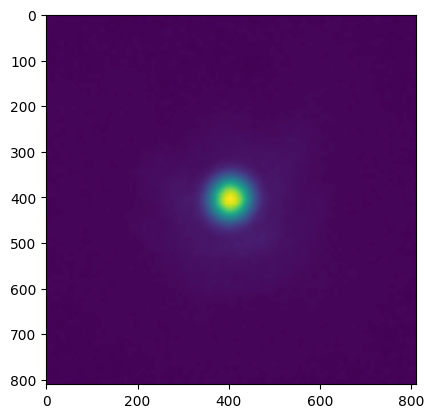

In [9]:
from scipy.signal import find_peaks
profile_integral = []
for layer in real_PSFs["ePSF_darkred"]:
    profile = layer[:,real_PSFs["ePSF_darkred"].shape[1]//2]
    profile = profile/profile.max()
    profile_integral.append(-np.cumsum(profile)[-1])
profile_integral = np.array(profile_integral)

plt.plot(profile_integral)
peaks = find_peaks(profile_integral, height = -110, prominence=10)[0]
plt.scatter(peaks, profile_integral[peaks])
PSF_darkred_centre_z = peaks[0] - 17*3 # Check how the peaks line up with the tails
plt.imshow(real_PSFs["ePSF_darkred"][PSF_darkred_centre_z])

In [10]:
from cucim.skimage.restoration import richardson_lucy as richardson_lucy_cuda
import cupy as cp

In [11]:
deconv_kernel = real_PSFs["ePSF_darkred"][PSF_darkred_centre_z-conv.shape[0]//2:PSF_darkred_centre_z+conv.shape[0]//2].sum(axis=0)
img_to_deconv = conv.sum(axis=0)

In [12]:
conv.shape

(234, 792, 336)

In [68]:
deconv_img = richardson_lucy_cuda(cp.array(img_to_deconv/img_to_deconv.sum()), cp.array(deconv_kernel),150).get()
deconv_img = np.concatenate([deconv_img[:350], deconv_img[-350:]])
deconv_img = np.concatenate([deconv_img[:,:deconv_img.shape[1]//2], deconv_img[:,:-deconv_img.shape[1]//2][:,::-1]], axis = 1)

In [69]:
tifffile.imwrite("deconv_img.tiff", deconv_img)
tifffile.imwrite("img_to_deconv.tiff", img_to_deconv)
tifffile.imwrite("membrane_cell.tiff",membrane_cell)

In [70]:
deconv_profile = deconv_img[300]
conv_profile = img_to_deconv[300]
unconv_profile = membrane_cell.sum(axis=0)[300]

Text(0.5, 1.0, 'Synthetic membrane cell')

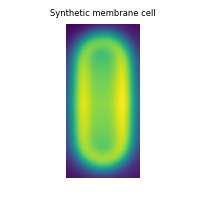

In [84]:
plt.figure(figsize=(2,2))
plt.imshow(np.concatenate([img_to_deconv[:350], img_to_deconv[-350:]]))
plt.axis("off")
plt.title("Synthetic membrane cell")

(-0.5, 335.5, 699.5, -0.5)

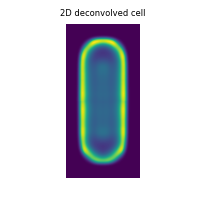

In [87]:
plt.figure(figsize=(2,2))
plt.title("2D deconvolved cell")
plt.imshow(deconv_img)
plt.axis("off")

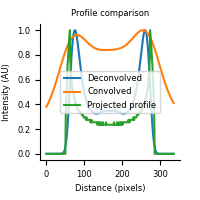

In [94]:
plt.figure(figsize=(2,2))
plt.plot(deconv_profile/deconv_profile.max(), label = "Deconvolved")
plt.plot(conv_profile/conv_profile.max(), label = "Convolved")
plt.plot(unconv_profile/unconv_profile.max(), label = "Projected profile")
plt.title("Profile comparison")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAABD2UlEQVR4nO2dd3xVVbb4v+f29AKhd0FBBVECkkCqUhRREAYRYcCGOOoMT3yjjMOPh4roQxksb3jyVBAbKnYYaQJBwQFEQ+81IZTUm5ty+/79cXJucpObm8JNg/PNJ59bzrnnrLPPWXvtstbakhBCoKKi4hNNUwugotKcURVERcUPqoKoqPhBVRAVFT+oCqKi4gdVQVRU/KAqiIqKH1QFUVHxg6ogfjh9+jQxMTEkJyczaNAgdu3aVavfrVu3joEDB7Jw4UJmzpxJaWkpy5cv5+23325giS+f9PR0lixZ0tRiNBt0TS1AcycpKYlVq1axY8cOnn/+edavX+/Z5na70Wiq1jFfffUVS5cu5eabb25MUS8bt9tN//796d+/f1OL0mxQLUgt6d+/PxkZGWzZsoXRo0czduxYli9fzsqVK7n11lsZPHgw69atY9OmTXz77bdMnz6d7777juTkZIqKiryOtXz5chISEoiPj2fTpk1VzjV//nzi4uJITk5m3759ZGZmcvvtt5OYmMiTTz7pOca9997L6NGjiYuLY8WKFdx+++2kpqbicDjYsmULw4cPZ/To0QwcOJB9+/YB8PTTT5OUlMSgQYNIT08HIDk5mb/+9a+MGDGCLVu28Mwzz+BwOBg9ejTJyckkJydjtVqrlWPcuHGe85w/f74B70ITIFSq5dSpU2LcuHFCCCHWrVsnxowZIzZv3iwSEhKE2+0WTqdT9OvXT5SWlgqz2SwGDBgghBBi6tSpYt++fUIIIZKSkoTFYhHLli0Tb731lsjJyREjRowQbrdbFBUViaSkJK9zpqeni7vvvlu43W4hhBAul0s88cQT4ocffhBCCPHQQw+JtLQ0sWzZMvHII48IIYSYPXu2mDlzphBCiJkzZ4off/xRbN68WQwZMkS43W5x8OBBMXr0aCGEEMXFxUIIIX777TcxadIkj4wbN24UQgixefNmMWvWLHH8+HExYcIEIYTwyFKdHA8++KAQQoh//vOf4o033ghY+TcH1CZWDaSlpZGcnExoaCiLFy8mMzOT2NhYJEkiOzubLl26YDKZMJlM6PV6nE6n3+OdOHGCAwcOkJKSAkB2drbX9sOHD5OQkIAkSQBoNBqOHz/OwIEDARg4cCDHjh1Dq9XSr18/ADp06EBISAgAHTt2JD8/n1atWnHzzTcjSRJ9+vTx1OwLFy5k48aNAOh05bdfOb7CNddcQ3x8PJMnT6Zr16688MIL1cqhNCU7d+7M7t2761jCzRu1iVUDSUlJbNmyhdWrV9OzZ08AT78jJiaGM2fOYLVaKSwsxG63ez10vujRowf9+vVj8+bNbNmyxdPMUejTpw8///wzoszJ2u1207NnT3bu3AnArl276NWrF4BHiSq/V36bnp6OEIIjR47Qvn17cnNz2bBhAz/99BOLFy/27FfxmhRsNhtPPfUUH330EdnZ2Wzbtq1WcogrzDlctSCXgVar5bnnniMxMRGNRsNLL71U429at27NxIkTSUpKQqvV0rdvX958803P9n79+hEbG0tcXBxBQUG8+eabPPvss0ydOpWXX36ZG2+8kcTERE6ePFnjuSIiIhg9ejQXL17kvffeIyoqiujoaJKTkxk8eLDf3545c4aHH34YrVZLSEgIt9xyC927d6+XHC0ZSVxpKq8C4LF6r732WlOL0qJRm1gqKn5QLYiKih9UC6Ki4gdVQVRU/KAqiIqKH1QFUVHxQ7NWECEEhYWFV9zkk0rLoVkriMViISIiAovF0tSiqFylNGsFUVFpalQFUVHxQ8AUxGw2M2jQIEJDQ9m/f7/XNpfLxUMPPURCQgIzZ84M1ClVVBqcgClIcHAwa9asYfz48VW2rV69mg4dOvDTTz9RXFzML7/8EqjTqqg0KAHz5tXr9cTExPjctn37dkaNGgXAyJEj2bZtG3FxcVX2s9ls2Gw2z+fCwsJAiVdr3MLNs1ufpVNYJ/5yy18AyCmyMevzPbQKMTB/bF+CDNpGl6tZ4HbDsXWw/yu4dBA3GnbYuvK9aTRPTx5D61AjAIt3L+Zc0TleTXwVjdSyW/GN4u6en59PeHg4ILtg5+Xl+dxvwYIFzJs3rzFEqpbdF3ez9vRaAI+CLNpwlLSjcmDTNW1CeSKlZ5PJ12RcPADf/AnOp3u+0gBx7GWgWMPaT/Zz16MvgCTx3v73AJhw3QQGthvo+3gthEZR78jISI81MJvNREdH+9xv9uzZmM1mz39GRkZjiOdFbmmu12eXW7B6T5bn8/cV3l81pH8C7yTJymEMh7gnYdLn/Ffw82xw3YJOcnNX1pu4t7zq9bM8q++KsCXRKBYkPj6ejRs3kpiYyLp163jwwQd97mc0GjEajY0hUrUU2r2bdUcuWCi0lofRHr5gIb/YTlSIobFFa3yEgK0LYfN8+fO1d8DoxRDWjrxiO8vznCznema4v+c5/Uo0aQsgqovn55XLsiUSUAty5513sn79eh599FGWL1/OY489BsBdd93F2bNnSUhIwGQy+ex/NBcq3lQhBAeyzADE9WhF1+ggoijkSMaFphKvcdn6WrlyDH0aJn4CYe0AOHReLqdurULY0/VB3nSOAcC9Zpbn54W2lq8gAbUg//rXv7w+T5s2TT6JTsfy5csDeaoGo6KCuISLkznFRFPIk45vucn6A6GmQlgJtOoJN46HWx+DYN9NxhbN7g9gc1kI8YiXIe4Jr80Hs+Ryur5DONEhBv5xcjx3t8qio3mnZx+LveV7QLTsIYYGoGKt5xIuRMavrDH+jSHZnxHqrlAj5h6HtFfgjZvkh+lK8hc78gOsnim/T5hVRTkADpZZkD7twunROhSBhneiZuHSB3v2UZtYVyBeFiRzN0+de4b2Uh4lYT34behSrrMuZ0LEp3Dvu9CuL9gK4fs/w2eTwVbk58gthLM74ItpINzQfzKkzvG525ELsnXo3T6c7jFyyqHf8oNxxz/l2afQZm5wcRsaVUEqUbFZ4Pp8CiGU8ovrenInrSOs753YMHCoQIvoOx6mp8Hwl0BrgMOrYdlIMJ9rQukvk+wj8Ol94LRCrxEw+g2okNKnIpn5JQB0iQ6mR2tZQU7lFuMY8JBnH0ve8YaXuYFRFaQSFS2IuzSPg+6uPOb6Tzq0jaFztNx8sNicFJQ4QKOF+Kdg2hoIiYEL+2D5nWDObCrx609hFnx4L5TmQ8dY+MMy0PruolqsDs/IXseoIDpFBaPVSNidbi7aKhyy4LQ8udiCURWkEhX7IHZ9CDMcMwkOjUCrkTDptbQNl4ehz+aVlP+o8yB45EeI6gb5p2H5XS3LkpQWwEfjoDATWvWCSZ+DIaTa3bMKrABEBOkJNerQaiRah8rD3pcsVs9+ZrcNjm9oUNEbGlVBKmG2FXjen+g9nbOiLTFh5XMzXcqsyJmKCgIQ1RWmrobIrpB/CpaPgoLGn+isM/Zi+OQ+uHQQQtvB5C8hpJXfn2QVlALQITLI851SRtlF5eVSoNHCrvcaQOjGQ1WQCjjcDiyO8o72vpg7ALwURGlmZVRWEIDIzjBtNUR2KVOSO2WL0lxxWOHT+yHj32CMgMmrZEWvgcwyBelYUUFCFQUp9Xxn0WpwHFvfvMugBlQFqYA5zzuNZnaxHSi/+QBdo+Wmx9lcHwoCsnI8+ANE94CCs7BsFOSeaBiBLwdHKXw+BU6lgSFUthzt+tbqp1keBTF5vlMqkdwiq9e+Zo0Ev74fIKEbH1VBKpC/459en3OL5Zvt1cRqJdeaZ31ZEIWITjDtX9D6Wrldv+xOOL838ALXF6tZ7pAfWw86E0z6DDrX3qnwXH6ZgkRVbWLlVFKQAq0W9qwEtysAgjc+qoIo2CwUHP7O6ytFQZQOKJT3QfwqCEB4e3l0q831UHQB3h8Bh74PrMz14eIBeG84nN0uOx5O+Rq6Da3TIc55LEj5pKDi6p5bUuq1b35wBBRdhFNbL1PwpkFVEIX0T7C4vG9uXoliQcqbEp2j5IfivLkUh6uGIczQNvDgv6BHCjhK5MnEH56TmzeNjb0ENi+ApSmQfVjukE9bA13j63yo8k561SZWfrHNa9+irmV+d/tW1VPwpkVVEJDN/7+XUFxpUiy/RL7ZFS1I61AjBq0Gt4CLhd7NCZ8ERcEDq2Dwn+TPO5bID+mZ7QET3y8lefDzYnhrgOwa47JBr+Ew42do36/Oh3O43J7rrtjEUixIXom3ghR3GiC/OfSdPCjQwlDXBwE4uQXyT1Ec7R0RabHKNzsyuFxBNBqJ9pEmzuSWcC6/lE5RwdSIVgcjF8iW5NsnIPsQLLtD/jzoUXnWuppJuXphuShf08Fv4PiPslIARHSB4S/A9WOqnSGviQtmK24BBq2G1iHlfbPIYD0ARbZKChLWHiI6gzlD7vNcf3e9zttUqAoCsOdTAIrb94OSY56vi+wOoPzmK3SMDJIVpKCOTaVrh8OffpFdyHd/ACc3y/+mSOieCJ1vhTZ9ILq7/J0xTPaJcrtAuORXtxPsRfL8ha1Ifm81y0OpOccgc6fsSFmRdn3h1hmy97He5EOw2nOuQvNKoylXssgguRIpsjmoeIZiVwlcfw/88rbsjqMqSAvDWgiHVgNQ3KY3nC5XELeQ+xgRQVUVBMpHc+pESGu46x8Q/2fYvQx+/xhKcuQmyKHvav59rZCg7Y3Q+07ZWrTpU2+LURlfI1hQXkYu4T1aVewohj53ywpyZC047aBrOcFmqoIc/AacpdD6WopNYd7bJDcGnQaT3jtJg/JwZJkvo7Md3R2GvQCp/w+yfodTW2RfrosHofCc3KmvDl0QGENldxBDmPw+sqsco9LuRugyWO77NACeDnqEt4KY9BoMWg0uyXvgothRDJ0GQmhbeTTr9FboeXuDyNYQBFRBnn32WbZv3063bt14//330evlWqW0tJQJEyZQWFiITqfjk08+oW3btoE8df3Z+7n8etNEih35Xpsk3ERWsh5Q7mKRWR8LUhmtTp6DqDwP4XLIzSdJA5JWftVoQaOTX5sIzxBvJQsiSRIRwXrynD4URKOB3nfBr+/JQ90tSEECNoq1Z88ezp07x08//UTv3r1Ztap8WO+HH37gxhtvJC0tjWnTpvHee83EP8dyEc5sk9/fOJ4SZ6VaW3JXaV4BdFKaWHXtg9QFrV62AqaIMmsRDDpjkyoHVJwDCaqyLSJID5J34Fixo1h+02e0/Hp4TYuaNAyYgmzfvp3hw4cD5bmvFHr27ElxsVxQ+fn5tG7dOlCnvTwOfSd3gjsOgKiuFNkrBzz5VhBPE6ug9KrLPF+zgviwICBPRpoioTgbzv67ocUMGAFrYuXn59O+fXugau6rXr16cfDgQW644QaEEJ61tivT6InjDn4rv94wFoBiZ7H3dklUGcECaBchj9NYHW7yiu20quCrdSUjhCj3w4qqqiByc7QaBdHq4bo7Yc8n8mhWtyENLW5ACJgF8Zf76oMPPmDo0KEcOHCAF154gRdffNHnMRYsWEBERITnv3PnzoESryqWi3D6Z/n99fcAUFKlY+wm3IcFMeq0tCmbOW7QZlYzI6/YjtUhK4BSSVTEbxML4DrZO5qjaxtMxkATMAVRcl8BrFu3jiFDymsIIYSnWdW6dWvMZt+xyo2aOO7Qd4CQo+ci5VxORWWu7p50mdX0QaC8Bq3XUG8LRakM2oQZMeqq9oXCg/RIyP0LpQy9FOSaFNDoIe8k5LSMcNyAKUj//v1p27YtCQkJHDhwgHHjxnnyYk2aNInVq1eTnJzMnDlzePrpp30ew2g0Eh4e7vXfYBz4Wn4ta15B+c0MN8jnlfwpSGN01JsZ/ppX4G1BlDL0UhBjWLnv17F1DSdoAAnoMO/ChQu9Pr/zzjuA3CdZu7YZmdXi3HJfqLLmlRDC08QKN4RTYCsABOEmVUEUlGHtDj466EBZc1RugillWOIoQQiBpExUXjtSjkE5us5nOqHmxtXprHhsPSBkF4xIuZ9T6iz1zAJHGiPl/SQXoUbfdcjV2MRSYtE7VaMgYUYdSN5l6BROSp0VyujaEfLrmW2yF0Mz5+pUEKWTeO1Iz1f5NnmS0Kg1EmmKBECSHISaqlGQq9CCnCuQLWx1FiTUpEPSyP5rUaYoDBrZpaSgQpw/ra6B6Gtkn7KTmxtU3kBw9SmI0w4nNsnvKyhIgbUAkGu+IF3ZA6CxV2tBOlyVClL9HAggl5UkK0iQLshT0SiVjwel3I+ubxA5A8nVpyBnf5GzIQa3hg63eL5WbmKUKQqTVh7ClDR+LEhZE6ugxEGxzelznysNpYlVXSe9ogUx6UxEGWV/MKXy8XCtPKHMsfXNPm/W1acgR8tGT64dIfsIlZFvlRUk0hiJSVc2xi855Ha1D8JNesLKlCfrKrAiJXYneWVJLKprYsl9EHkfk9ZUvQXpEi87WRZfgvO/N5jMgaCKggghrmz3CU//Y4TX10pGxTBDWK0sCJQ3NTKvAgVRrEeYUVft0HdFCxKkC/IM9VZZBkFngGuS5ffNvJmlA8jKyuLtt99m+/btOJ1yc0Gn0xEXF8eTTz5Jx44dm1TIgJFzHPJOyJNV16R6bVJGWoJ0Qeg1Za4jUvV9EJAV5PAFy1UxknXOR7K4yoQadVCmIDqNwdOXs7lsVXe+dqTs2XtsHaTMDrzAAUIH8vzFgw8+yMsvv+y1ce/evbz++ussWrSoSYQLOIr16DZUnrSqQEUF0SCPvkgaByEGPwpSwWnxSqe6QKmKhBh0SGVNLI0weCyx1ekjFr3nMPk163fZ7SesmYQ/VEID8I9//IN+/aoG8Pfr1+/KUQ7wObyroChIsC4YScgKotM5vcJKK3M1DfVm1TCCBXK8vk5XNmAhDJ6+XKnLR/mEtYUON8vvm3H+Xh3AwIEDy2c6gaCgIPr27cvf//532rVr12TCBZTSAnkEC8pHUSpurmBBnHZZQbQ6h99Ddric0NsWhrLcgb8mFsiVigsQbj0mvR8LAnKyiqzf5Yrr5smBFDdg6AB27drl9aXNZuOnn37ikUceYfXq1U0iWMA58aM8OdX6OjktaCWUmxikC6LYJt9YrdZ/mpqrqYmluJl0jvavIBqtFRegESaMZX2QahXk2hFyKqITm5ttrLrPBrbRaOT2229nwYIFjS1Pw1FheNflcuFweFsHvVtPe0N7wjXhIMJpb2iPTh+C1Vq9krQN1tAxTIskHFiKS9Brr9xRc7vdSscwLZ3CdH7LpF1wME6pPSEigmDJRXtDe/Quvc/f6Nv0RavEqp/ZJnv7NjMkUc2Y7p49e/jP//xP1q9vumG4wsJCIiIiMJvNl+fZ63bBwmugNJ+iB34g0xVdZSg7tzQXm8tGpDESl1uLxZGLhIb2odU3MYWQEzcIAe0ijOg0V6aCCCE4VzbM2yHC5Ldfdr7oAgI3YfpWaDUuCmwFmHQmok1VFzqVJIlOpz4jdMciGPQY3PnfDXYN9cVnHwSgR48eLFmypEmECjiZu6A0H1dIOzKdUQSHBBMTE+N1zXqLnlJnKe1D2mNzaMmzy/EO3SK7VSkbL7KLcLjcdIgO9jvi1ZKxO1w4gouRJIkebUKrLQ8hBM4CuZMebeiEXu/AUGwgWBdMx7COVfbNzs4ms8Md9NL+E+3RH+COVwOWnihQ+OyDKGRmtsClxHxRNnrluPYuBBATE0NQUKWsHFYJjaTBaDLiRo9GyNZAb9Sj01T/4JtMTpw2JxqtAZOp+bWhA4EDB5LOgUmvrVJuFXG6nWj0ZeWmD8Jk1KKxa5D0EiZT1QjEmJgYThdZcIR0RFtwQl7Ep+0NDXYd9aFKmyAzM5PFixczcuRInnii+fvr14ojZcO73RMBfNaASpI4jSTn3QV5H1cNGTiUfoe9mkTWp0+fJiYmhtTUVBITE5k1axYlJTVkhm9AtmzZwjPPPFOn39jLUvkYtBqeeeYZtmzZ4nO/8rKScAvhiSqszjNDkiQ5nVGXW+UvjvyrTnI1BhqAjIwMFi1axB133MG8efNYuXIla9as4dtvv21q+S6f/NNyLlxJK6f2rAZvBREIITexKmcKrIxBJz8E/jK9JyUlsWnTJtLS0ggODmbu3Ll1vIimRVF+5Vqrwynk5pUQWlyivCJSyrZauiXIr0pF1ozQAHTr1o2TJ0/y1Vdf8X//939ER0ej1dY9/9Kzzz5LQkICU6ZMqTJKtHLlSlJTU0lOTuaXX34JjPS1QRm96hIHQZGer4UQlNid5f82J1a7G6tdUGR1YrWD1e6m0Grz3q/Sv9Ml+67ZnTV7pUqSxJw5c/juu+/49ddfSUlJISEhgddeew2A7Oxs7rrrLpKSknjggQcAudxuvfVWBg8ezLp18rUkJyfz9NNPk5iYyJNPPgnAPffcw/nz5wF47733+N///V8KCwu5++67SUpKYuLEidjtdo8sv/76K48//rinLAYPHozb7Wbt2rUkJCQQHx/Pp5/KOYvT0/cwaVQq0yaOY+/e6hcC8lgQocHtLrcgNStI2fok536VZ9WbETqAgwcPsmrVKu655x569erllbKntlRMHDd//nxWrVrF/fffD8i+Xt9++y0//vij/w5vQ3DkB/m1knNiqcPF9f/PV1z02Ro+V+XzxwZjctXOwdNgMGC323nuuef46quviIqKYvTo0UyZMoVXX32VBx98kHHjxuF2u3G5XCxYsIAdO3Zgt9tJTU1lxAj5OsaMGcOiRYuIi4vDbDbzhz/8gc8//5y//OUvfPnll6xYsYKlS5dy5513MmPGDF588UVWrlxJly5ygorY2Fj+/Oc/43Q62blzJ4MHD0aSJF588UU2b96MVqslMTGRCRMmsHD+PF5+8x0SYvsxalj1Q7GKBQENLrdAg1zJCmoom9A28qx61u+yb9Ytf6xVWTYGGoDrrruO559/nvXr1zNz5kzuvvtukpOTGTt2bE2/9+AvcdzatWsxGo0MGzaMKVOmUFRUOUFbA2EtLE/to6ScaSAcLnetvKBtNhtGo5G9e/cyduxYkpOTOXv2LBkZGRw6dIikpCQANBoN2dnZdOnSBZPJRHh4OHq93uNMevPNsptGx44dKSgo4J577uG7774jJycHjUZD69atOX78OAMHyilNBw4cyLFjx7xkSU1NZdOmTXz22WdMnDiR7Oxsjh49yvDhw7ntttsoKCjg0qVLXLp0kW7X9CLIoGPAgAHVXpuXBakQh16jBQE5ZxaUV2jNhCrDM7169eJvf/sbf/vb3zh+vPapWfwljrt48SI5OTls2LCBJUuW8Pbbb/Pcc89VOUbAE8ed2ARuhxzi2boXVJisCtJrOfiCXBs73U6O5ckPz3WtruNUTgk2kY+kKaJVUCvahLSp9hRuIThxqQi3EDjdAr3Wv4VcsGABY8aMYffu3axatYqIiAhcLhcajYY+ffqwdetW7r33XtxuNzExMZw5cwar1Yrdbsdut6PTybesoiUWQhAWFkarVq1YtGgR48ePB+SMljt37mTAgAHs2rWLXr16eckyceJEXnvtNY4fP84bb7yB2+2md+/erF+/HoPBIDeTJS3RrWM4e+okN3Toz2+//ca4ceOqKQtFETS4KnXSvRI3+OLakfKyECc2yytw6f3P2DcWGoDJkyfz6aefkpOT49mQk5PDzp07mTy5dj4y/hLHRUZGkpKSgiRJ3HbbbRw4cMDnMQKeOE5xTvRhPSRJItigI9igI0ivxWTQEGTQEmo0YNBqMerk74z68v18/Yca9Z4cUdX1Q9LS0khJSSExMZHi4mLmzp3LK6+8wr333ktKSgqjRo3CarUye/Zs3nvvPZKSkpgyZQparZbnnnuOxMREhg8fzksvveT3cidMmMAbb7zhsfyPPvooa9asISkpiX379jFx4kSv/W+88UbS09MZOlTuA2g0Gv7+978zbNgwUlJSeOCBB7A5XTzxzPPMfuoR7h49mqio6rPGKwoihITbDRJSlW3V0q6vvNCOsxSOb/S/byMiCSGE3W7ns88+45tvviEzM1Oe4ezUiXvuuYf77rsPg6Hm8f309HQWLVrEihUrePnll+nevbunD7J3714WLlzIhx9+yGeffcbBgweZN29elWP4siCdO3eu30y62wWv9YKSXJi6GronYLVaOXXqFN27d/cal7c5bRwvOI5G0tCnVR8OnS/EKRWi0ZmJNEZWmeSqzKmcYixWBx0jg664NKS5RTbOFZQSbtLTrXWI330zLZmYbWbczgi0Ipw+7cI4mHsQgOuir6syn1Tlfqx7Xl5H5MZxML55LB2tA7njOGXKFKZMmVLvA1VMHNelSxeeeeYZHnvsMd555x369etH586dSU5Oxmg08vHHH/s8htFoxGgM0AOWuUtWDlOEvF6GH9yUD/ECuNwCytwpahrmBTDqNFgAWy1GsloayjXVNMQLFayEkHC75SaVJEkIIWrXD7nh3vKFduwlckb7JqZREscBVYKxGhxl0qnnMDlxsh8qzoHIN1N4mge1ubGmstljq6PlpPWvLYqCGOuiIChzSXI/xCVctQvj7niLnAa24Kyc0OGGMfUXPEBcqd51cLBsObPeo2rcvfIkoXyMWo7hg6cPcmVaEFnpjfqa58UqWhCQLbGnoqEWZSNJ5algldSwTYyXgvz4449NJUdgubAP8k/JS5X1qhocVRmldtNIGpQJcamsaGrbxAJ5qNflvnISXrjc5ROgplpYEKWsJM8EYR0mCxUUBTm6Tl6ktInxuupNmzYxdOhQ/vrXv7Jv376mkunyUdb96HW7vDpTDfiyIBpJrjGdbmeNzQOdVuNxdVdq3CsBpcmo12rQ1RDrIoTA6ZbnaJQJQpebGv2xqtC+P0R1l0ezmsEyCV5XPX/+fH7++WfuvvtuXnjhBW666SYWLVpU7XIFzRIh5IU5QV7htRYo5l9C8lgAjaRHQsIt3J5lEfzhrx+yfft2kpOTSUpKIjU1lV9//bVWctWF5OTkek/AFhUVkZycXOV75VoqL2Lq8xiOItzCjSRJaCW5z1cvCyJJ8igWeJbnbkq8FMRut7Nq1Sr+8Y9/4HK5mDNnDt26dePuu1vQ2taXDsnrhGuNtWpegW8Loi0bgQEw22quIIIM8kNU6vB+EPLy8nj88cf59NNPSUtL4+uvv0bTQgKrlMVyFOX3h1JGEhIaqZ59EIX+k+TXE5ugMKsOEgcerysfNmwYmZmZLFmyhK+++orx48dz77331nqysFmgNK963gam2s2dVFQQjwXRSLQKagXUrh+i1LKldu9916xZw5gxY7y8DHr27FnFiXDLli2MHDmSsWPHctNNN7F///5qHQp9OTAq+HJatFqtTJ48mdTUVO6++27PhO5TTz1FUlISs2f7zktVFwuilFGroFZoNcoIYD0sCMgJrrvEyetHNrEV8VKQMWPGMHPmTNq0kV0r3n33XUCekW0RCFE++lG27offfe3FYC9G2IqQHKVoHVbctiIkRwk6ZylBboHkKMVtK/Ls6/NfCILKHiKrw3tIMysriw4dOnidWnEiTEtL44YbbmDlypUAOBwOvv76a1555RXef/99YmNj2bNnD06nk19++YXBgwcjhGDBggWkpaWxfv16nn/+ea9jK06LAF9++SXjx4/n3Xff9fhdPfDAAyxdupRff/2V3Nxc0tLSGDWq6kifEKJOCqL0P4J0QV4WpM59EIX+sjczv38s36smQgfgdDqx2Wx88803zJgxQ+5wOZ18+eWXPPLII00mXJ05nw45R0Bnqtk50VECL8sPbtuyf4WK0dPX1+a8f8vCqA9GI8mBQnan2zMs2qFDhypOgsePH/dUOgMHDmTbtm106dKF/v37A9C5c2fy8+V8tsqDvWbNGu6//34vB0aTyeTlwAiyBRkzZgwPPPCAx2nx4MGD7Nq1ixUrVuBwOEhISOD48eMex0PFobEidqcbV5n/VG3mQBQLopW0KP35OjssVuSGMfDDX+VMmGf/DV3j6vb7AKED+Pjjj1m+fDl79+5l1KhRCCEwGAyMHj26SYSqN3vkmpjr7pRn0BsRSZIw6bWU2J2UOlweBRk1ahQpKSk8/vjjtG/fnsLCQnr06OHTibCyAyJUdSh0uVzVOjACPp0We/fuTVxcnMdTwuFwsGfPHk9KJ1+DBiVl1iNIr/VYhOpwuBw4XHL8j1ajRaORlcHlBo22Hk0skDNf3nAvpH8Eu95tWgWZOnUqU6dO5d///jeDB/t3y2i2uBywb5X8/qb7a95fHwx/kzuAWUVZFNjMtAlug8MeTE6RnZgwA23CjBzOOwJA2+C2tAqqmpnDcyzkjrocSOUissxLIjo6miVLlnD//fcjhECr1TJ37lwWLlzIypUradu2Lc8++yzbt2/3eWjFoXDkSDkbZEUHRo1G49OBccKECUydOpWsLPn6pk+fzvTp01m2bBkAs2bNYtSoUYSHh5OYmOjTgpSU9aWCDTU3r5TE3wB6jR5tWfpRtxBolSZWTTEhvhj0qKwgB78By3wIa/wkhpIQQsybN4+5c+fyhz/8oYpLstKebQrqlPbn6Dr4ZAKExMDTh0Fb1YumOmdFxcmuXUg7SkuDyCux0y7cRJtwE+eKzlFgLSDKFEWH0A5VjlmRghI7Z/NKCDbo6Nmm5vmX5szxS0WU2J10iQ4mMti/s2pWURb51nxPGV2yWLlgthIVbMBoKiK7JNtn+VV3P7x4bzhk7IDk2ZBcNUSiodEBzJgxA8AT+tkiSf9Efu37B5/K4Q/F/EuShEuUj2IBhOhCKKDAd4bySii1bandJYec+skf1ZxxC0Gp0sSqhQVRyia4zJJqfXTS69zEUhg0XVaQX9+HoU83evZFDUDbtnIXNT09na5du2Kz2XjxxRc5depUowpTb4ouweE18ntlDL0OKOa/4kShcpONWtm72O6y+/5xBfRaDXqtBkH5A9YSKbXLI3E6jQZDLbJFKgqilJXXMC+X0cQCeTQytJ2cfXHfF/U7xmXgdfVvvfUWAK+88goPP/xwlSHEZsvvH8mRg50GyoE3daSiL5biSqXU/gatXGM53c6qC8FUQg7CkmvclrwsW1GZ7CFGbY05BApthZ5QW2XRTs8w7+WMYilo9RD3J/n9z4vkOJ9GxEtBLBaLx10hLi6uVoFSTY7bBbvlziexD9XrEP4siFZT3sSojctJSNmCO0VXgIL4WzzIs2+FMlHKymNBKvhi1VtBQL6vQVGyh0Qje/l6KciDDz7ImDFj+NOf/oTVaqVbt26NKky9OLFJjh8wRZR7gtaRin0Qj6tJhZLpGCpHFNamH6KsaVhsd7VIz16XW3hGsGqjIEqZVIy6DMhEYUWMYTC4zIpsfa1RF/70UpAZM2awceNGYmNjMZlMnmHBZs3OpfLrTZPqHejvy4JU7GAbdXLbujYKYtBpMOjkwKuW2Mwqtsvey3qtplZRhJX7H4D3RGF9fLF8MWg6GMPlJIB7P7u8Y9UBrxJYuHAh/fr1Y9CgQQwcOJBBgwbV6WD+EseB3LeJjY29PIkrcumQHHmGJI+Z1xOldvOyIBXa3krb2uV2eSbEqkOSJI8VOXj0ODExMSQnJzNo0KBqcyBXZubMmZSW1n7NkS1btnD06NFa7+/vHhSWyNcXbtLV2P9wuBzMmTmHaXdPY8e2HZ6MkcNuu42S4qKymfQANLFATvqXMEt+v/G/wGa5vOPVEi8F+fLLL0lPT2fnzp3s2rWLnTt31vpAFRPH9e7dm1WrVnltt1gsgY8x2f62/NrnLtnBrZ4oCiJE+QNR0YJoNVpPwoGj+UdrbC6Ela0Ca7E6SUxKYsuWLbz11ltVBj3c1TQVFi9e7DdJdGXqqiDV4RYCs1VWkIor2fpa+VgIwdH8oxzad4iPVn9EclKyJxGHl16Jy+ykV2Tw43KsSNEF+Klxlgb0UpCBAwd6Zl/rir/EcQBvvPGGJ01mddhsNgoLC73+q6Uwq9zUxv+5zvIKIShxlMj/zhKsTisljlKsrlJsbitWZ2n5dkcJNqcNq9OK1WnFbDN7bav88IQZdeg0GpxugbMsRLF///5kZGSwZcsWRo8ezdixY1m+fHm1qUWLioqq9cKdP38+cXFxJCcns2/fPpYvX87s2bP54x//iBCCp556ipSUFG6//XZPhv5XXnmFuLg4pk+f7lMxe/fuzYT7JjJhZDJrv/2SEKOOadOm8cQTTzB8+HAuXbrE5MmTSUpKYtSoUVzMucjr817n1LFT/PHuP3L06FGPawvI/RCb1crDUx/iobEP8adJf7r8PGc6I4woy21wYW+jODF69cK2b99OUlISUVFRnowUtbUi/hLHmc1m9u3bx9///ne/x1iwYIHPdEA+SftveWi3Szx0rltTEOQ1CW/9pPpk1nVhx6QdnkkykJtZkcF6zlCe1DotLY3evXsDcnmkpaXhdru55ZZbfKYWBTxeuA899BCfffYZS5cuZdiwYezcuZPt27fLTUK3m2nTphEbG8tdd93F6tWriYqKYvPmzezYsYNXXnmFOXPm8MMPP7B9+3YOHz7MnXfeWeUaMjMz+Wz1BhySgaljhjFrxjQAbrnlFv7nf/6HVatW0alTJz766CM+/PBDXn/jdWbNncWOn3bw4fcfYjB7j3hKGomvVq4gMTmZOeP+ztpv1rJ06dI6Z5avwnV3yGmcug1tlLVEvBRk9+7d9T6Qv8Rxixcv5qmnnqrxGLNnz+bpp5/2fFbyYlUh9wT8/qH8/rY59Za5IYkKlpso/972M0lJSYSFhbF48WIyMzOJjY1FkqQaPXN9eeEePnyYhIQET/+gcvDVwYMH+frrr9m6dStCCDp37sypU6fo168fkiTRp08fQkOrusF069YdjSkMA9CtSxdPEkHFT6tyGtNVq8ub0K1MrbCYvfsEWkni5NEjrPs6nWUr3sXpcDIi1Ts/cr2QJOiecPnHqSVeCnLgwAGef/55SkpK+OGHH1i4cKHPFKG+iI+PZ9GiRfzxj39k3bp1DBkyxLPt+PHjnozux44dY/78+T4nIWudF2vLAnlBzp7DoGt8reSrTJAuiB2TdiCE4HDeYQA6BHcnI99GkE7LNZV8qYQQ5NnyuFR8CZAToSlDmEG6qv2FIIOOEIOWAYOHsPyjT+kYJVuYzMxMz0PtL7Uo+PbCPXToEJ9++imzZs3yWBC9Xo/L5fL8ZsKECcyZM8fzm9zcXPbt2yf3G44e9Rmae/rMacwFBbSKDOPcuUxat24NlCugksZ03Lhx7Ni5g87d5YpLr9ETbYrGQiUF0UC3nteSkjiEhDGype4V7p36tCXgVf088cQTLFmyBIfDgVarZcOG2q9fXTFx3IEDBxg3bhyPPfYYAB9++CFr165l7dq19OrV6/Jm6IWQvTp1psuyHpIkEawPJkgfhElnwqQzYdQGY9IGEWIIJljv/R9iCKFTaCeC9cGYdCaKHcWebdWN9ihZFvNKHD5j1WtKLTp9+nQ2bNhAamoqqamprF+/nn79+hEbG0tcXBwpKSkcOHCA1NRUXn/9df7yl78wevRocnNzSUlJITU1lRUrVtCuXTuGDx9OXFwcb775ZpX0oVaHi7btO/LK3Gd54J7hPPPMM1WWvxgzZgwZGRkkJiay4uMVTHp4EhpJg07je7RLg8T4SVPZvOlHHhor90PWrmv6JAx1RlQgKSlJCCFESkqK1+emwmw2C0CYzeaqG4tz63y80tJScfDgQVFaWur5zulyiv3Z+8X+7P0i21Iq9mTki1PZRdUe40T+CbE/e784Yz5T4/ncbrc4lV0k9mTki+MXLcLtdtdKzri4OOFwOGq17+XicrvF8YsWcX3f/n6vuyJnzGfE/uz94kT+iWr3OZ0jX3e2pdRTvg6X9zX5uh/NDS8LMmLECKZNm0ZmZibTp0/32ZlrNgRXE5tRRyo60SkT31o/XrhtguVwZIvdQqYl0++QryRJdIiUQ1CL7U7Om/2vuw7yCFWfPn08TS1RFvpqsToosjo9yyyIssjFYpsTi9UhexDXcVRHCMEFs5ViuxMk6BBZjct5hf0zLZlY7HJzSikLXyiz6RUHzOrtsNiEePVBZs+ezYEDBzh48CC9e/emb9+6O/61NJQHXELOJwv+FcSkM5U5Nbox28zEBMd4zSJXxqDT0DkqiDN5JeQU2dBqJNqEGattlj3//PMU25ycLyil2O7E6nBXefB1Gg0aqeq6iJqyqMZgg5aIID3BBv/OhpcsNnKK5Jnw7f/eiUHn37Xd7rZ7spdoJA0mXfUKVdGjV8nP668yaa54KcjIkSNZu3YtN9wgrzQ6efJkPvrooyYRrCGpeKM8biaShLJIlL8QU51GR8+onhzNkyfmcktzCdYHE2GIqPZhjAg20N7l5rzZysVCKw6Xm/YRQV6KKITAXOogp8hOid3bRUUjSWXuK3KsuNNdnsdLr5PT7ChZHZWl4XKKbJj0WlqHGokM0ntNfLrcggvmUnKLZRf+9hFBXhODvsrLbJfnfhR6RvX0u/pvuUevLKco+6t83OaOZxnonTt3curUKf75z38CciKHM2fONKlwgUav13uGV5V10m1OG26HnPDM7rAinA7cTqniWjs+CZFCsNgt5DpyySUXZ4iTUEP1UYRhenAEaci2WMk12ymwlBBu0qHXanC43HLzyV3uNBlm1BFi1GLSadHrNOVu426BzSk3p0x6nUfJhBA4nG5KnS5KbC4sNielTjsZpaVkaTRe5yq0OnGVnSsmzEiYXmD1c8FF9iLOF58vvxZDGC67CxfVu567nTaE047dKiuGW7ixlloROsVrQV4nXZIk9Hr/ycWbEs/yB6GhoURFRRESIq8BodfrWbFiRZMKF2i0Wi2dOnUiMzOT06dPA7I/UXZpNlpJi07YKXW4cQTrMdfgyepwOyh2FGN32XG6nZQYSgg31JyHy+1wUVDiwOkWnK+0TSvJ7vIhRh3WEomaeyzVoy1zliy2uXyeS6eRJzPNpVpqSotXaC+kyF6ETqOT42P0UKrx7ytWbHOSX+LAotfglArkDO9BAn2FTPvKOjT1WTC2sZBEJTtnsVgoKCjwmD9l0cemoE4x6XXA5XJ5nCkP5R7i2a3P0iakDeH5T7An08zzo64ntXf1HdCKfHPsG97fLy/2Eh0UzT+S/0GUqfpVmACcLje/nMjl94x8coscRAbr6d85kvhrWtUqi3pdcLjcbDueQ3pGAQUl8rkGdIki7ppWNebbzbfm8x9b/oO8Utkr4uG+D3NPzxryjZWx+fAlXlpzkJs6RWCJ+icXiy/yauKr9GnVx7OPXq9v1soBlfogf/7zn9m9ezcdO3b0rCnXlEkbGgqtVuu5MU6tk/P28wQFBVFQ6OScxUVQkKn6JAKViO0Uy6K9iyh1lnLefp70/HTu6F7zgqHD+gUzrN9lLjFXC0zAyJu6MPKmuld0v2f9zgGzvFxekC6IAR0H1LpcTEEmzllcRBU60UYUct5+HqfWWevfNxe8FGTPnj1VnAyvdJRYc4PWwCWr3DkON9U+6UPPqJ78NPEn5m2fx/cnv+ejQx/x+ZHPiQmOYcZNM+gR0aNB5G4oTppP8r97/pec0hxPrMfoHqOZGz/X72hdZRSXf4vVSZuysOXaxPU3N7yehNjYWLZt20b//v09ncLg4KZfBqshcbjlppZeo8diVUJN69ZpNGqN3ND6Br4/+T17s/d6vs8tzeW9Ee8FTthG4KV/v8SuC95xKze2vrFOygEQZpLLsMjqpKNGfq+UdUvCS0F+++03fvvtN89nSZLYtGlTowvVmCgJB7SSlqIyBQmrgwVRuLfXvQgh2HVhF5sy5DLbeWEnJwpOABCiD/H4LdUUiNRYCCHIs+Z5BhwAL+W4rcttxLaNZWyvuocyh5aVocXmLF/7sRZJwJsbXk/C5s2bm0qOJqN8bRCNZ+IttB4KEqQLYvL1k+kQ2sGjIABjvh3jtd/TA57mwRsfrL/AAWT5geUs2l194NE919xDSpeUeh1bqWTsTrdnta6WMO9RGR3gM6OiwpXYSa+IUqu5KriZhNUiWUF1DO04lNi2sfx68VcijZEAFNgKPNsX7V7UbBSksnJUlDe2bSxDOg7x8avaEWrQoZFk9x3F3aTFWpAWnVHxMlGi69xuuYKICNJfVhPIoDWwbKR3sou+H3i77DyyzjtjfmZRJmGGMIJ1wXQO60x0UDQGjYEgXRAP932Y/9v7fziFk8dvetznOZfsWYJO0vFov0d5b997WF1WbC4beaV5ZFgyKHGWYLFb6BTaya/sP038qR5X7BuNRiIiSE9+iQN3IMNuGxkdQNeuXZtajiZDaWIpChLpx+WivozpOYZvjn/j+bzjwo5q9/3t0m9en4d3Hc6bv78JwPhe44kJjvHafqnkEv9Ml70fRnYbyeLfFld77HNF56rdNrZn/VIm+SMy2CAriLuFK8jVjHLTFL+/iODAK8jfbv0bQzoMochRRIg+xGvbX7f+1e9vPzj4gef9tye+pXtEd6/tp8ynfO5bHf+d+N9en4sdxYTqQ0nqnFTjb+uK4t+llK2qIC0QZRTL1YAWJEgXxMjuI31um/fLPM8Iki8+O1KeA+qN397we56K+/oiRB9Sq0nMQBEZrCiI4rjYQvsgVzOVLUhNqf4Dzfwh81lxcAWnC0+TZ81Dr9F75gt0Gh03trqRfTn7cAkX/WP6+zxGenY6WklL39Z92Z+737McmnKsaFM03cK78cfr/9hYlwWUVzYutYkloywE061bN95//32Pl+b333/PSy+9hF6vZ8CAAbzxhv+asDFR+iDK8ub+3L4bgtu63sZtXW9r1HM2Fkpl4ywbImyJChKw9Yj9JY676aab2LZtGz///DOXLl1qkHXC64syitVUCnIlE15Wlk5Xy7UgAVMQf4njunTp4gkhNRgM1a4TXqfEcQFCaRcrORUiG6CTfrWiNLGUsm2JfZCAKUh+fr7HJb1y4jiFXbt2cenSJW655Rafx1iwYAERERGef585sQKMEuXmVBUk4ChlqTax8J84DuR8UDNnzuSDD6ofipw9ezZms9nzn5GRESjxqkUZxVKiXCODWsCaKC2EqGDFi1f+fFUrSHx8PBs3bgSokjjOYrEwceJE3nnnHdq0qT4QyWg0Eh4e7vXf0Cg3zeaUa7nWoXXzWlWpnlahsoLYypx4r2oF8Zc4bvHixZw6dYonn3yS5ORk0tLSAnXay0YZxbI5yhQkTLUggUKpbOyOMm+FFqggAR3mXbhwodfnd955B4A5c+Z4UmE2N5SbpvgLtQpRLUigUCyIW0houco76S0VpQ+C0BARpK/VqkoqtcOo0xJu0qHkJ2yJFuSqfxrKlwaTaB2qNq8CTeswI6DOg7RYPDdNSGoHvQGQy1S1IC0WTxMLTVltpxJIYkKNnmXY1D5IC6Q8HaYk30yVgCI3W8uzP7Y0rnoF8dRqQqJ9RMvK2dQSaB8ZBKLlJm246hWkfEFLDZ2iruwUR01Bp6gg1D5IC0ap1YSQym6mSiDpFBXsWV5btSAtEGeFTrqqIIFHLlNZQZwuVUFaHIVWJbOilugQdR4k0LQKMaDTyHmQLdaWl3pUVRCrnH82zHR56X5UfCNJEuEmueIxqwrS8igokW9aqxB1BKuhiC4r2/wSWxNLUneuegXJK5aXqWkbpvY/GgqlbPNUBWl55JeUKUiEqiANRdtwxYJczppZTcNVrSDFNieFZdE87cNDathbpb60j5DLttBqp9jmrGHv5sVVrSBbj2ZDmTdvhBpq22BEmJSyFfx0LLtJZakrAVWQZ599loSEBKZMmeJZAxDkNQEfeughEhISmDlzZiBPeVmsO3ABynyxlDUsVAJPedm6WXfgYpPKUlcaJS/W6tWr6dChAz/99BPFxcX88ssvgTptvTlvLuWH/RdAUhWkodFqlIU6BWv2nudMbvWpVpsbAQu5rZwXa9myZdx///2ebaNGjfJs27ZtG3FxcfU+19ZTBzhvycUtyur/slchyj1GBbKnrvJdxf1yi+2s3pOFQ19KTIiNEuQVplQaBqXyiQqzczH/FA98eIGxN3cgJsyERpLQakBe7r3281Dtw6JJ7H5DwwhcgYApSH5+Pu3btweq5sWqTc4skBPH2WzlQ4HVJY6bs/W/yeM3n9tqTSSEREJJ2UfVgjQcSuVTpDlMSLfDmIHlpy/vmNHcQlr3mrPZXy4BUxB/ebFqypmlsGDBAubNm1fjucIN0RSUtPaqcKqveyQqV04aqTxeWqORiDJFMbTj0BrPq1I/hnYcSr+YfuRb83G5BRarE5vThctdbu2pY6hIeLDvZyjgiADx+++/iylTpgghhJg/f7745JNPPNu+/vprMWfOHCGEEI8++qjYvn27z2NYrVZhNps9/xkZGQIQZrM5UGKqqNSJRsmLddddd3H27FkSEhIwmUzV9j+aInGcioo/JCGabxxkYWEhERERmM1mVVlUmgS1Z6qi4odmvcKUYtwaYxkElSuHsLCwgIUuNGsFsVgsAI2yDILKlUMgm+TNug/idrvJysqqUiMUFhbSuXNnMjIymlXfRJWrbjSUXFeNBdFoNHTq1Kna7c11pEuVq240V7lA7aSrqPhFVRAVFT+0SAUxGo3MnTsXo7F5pQpV5aobzVWuijTrTrqKSlPTIi2IikpjoSqIioofVAVRUfFDi1SQ6mLfGwuz2cygQYMIDQ1l//79AHzxxRfEx8dz2223kZmZCcDhw4dJTEwkPj6eH3/8scHl2rlzJ3FxcSQmJnL//ffjcDiahVwXL14kPj6epKQkUlNTOX/+PD///DPx8fEMHTqUffv2AXDhwgWGDx/OkCFD+OijjxpcrlrRhK729SI9PV088MADQgghXnrpJa+4k8bCbreLS5cuialTp4p9+/YJh8MhBg8eLGw2m/j555/F9OnThRBCjB07Vhw9elSYzWYRHx/f4HJlZWWJkpISIYQQzz33nPjiiy+ahVxOp1O4XC4hhBDLli0TL774okhMTBR5eXnizJkz4o477hBCCDFz5kyxYcMGT3mWlpY2uGw10eIsSOXY923btjW6DHq9npiYGM/nY8eO0adPHwwGA0OGDGHv3r0AZGVl0atXL8LDw4mOjiYnJ6dB5Wrfvj1BQXICPIPBwJEjR5qFXFqtFo1GftQsFgvXXHMNWq2WqKgounTp4gnB3rlzJ6mpqeh0OmJjYz3WuSlpcQpS2/j2xqSiTCCnOYKKi/M0rqxnzpxh/fr1DB06tNnIlZ6ezq233srbb79NfHy8l1w6nQ673Y7D4fAoUnO5t83aF8sXtY1vb0wqygRyjQl4bjY0nqyFhYVMmTKF5cuX43K5mo1c/fv3Z8eOHXz++efMnz/fSy6n04nBYECv1+N2u9FoNM3m3rY4CxIfH8/GjRsBWLduHUOGDGliiaBXr14cOnQIu93O9u3b6devHyA3eU6cOIHFYiEvL4/WrVs3qBxOp5OJEycyd+5crrvuumYjl91evuxBREQEoaGhOJ1OCgoKyMjI8CjCwIED2bJlC06nk927d3PDDQ2f1qdGmroTVB+eeeYZMXToUDFp0iRhs9maRIY77rhDtG/fXgwePFgsW7ZMrFy5UsTFxYmUlBRx9uxZIYQQBw4cEEOHDhVxcXFi/fr1DS7TihUrRHR0tEhKShJJSUli5cqVzUKuHTt2iISEBJGcnCxGjhwpsrKyRFpamoiLixPx8fEiPT1dCCEPMtx+++0iLi5OfPDBBw0uV21QXU1UVPzQ4ppYKiqNiaogKip+UBVERcUPqoKoqPhBVRAVFT+oCqKi4gdVQerA6dOniYmJITU1lcTERGbNmkVJibyAwsyZMyktLfX5u6VLlzaajBMnTsTp9L0O4IULF5g7d26djpecnExRUVGV74UQ3HfffVzpswSqgtSRpKQkNm3aRFpaGsHBwZ4HbvHixR5Hwco0loJs3bqVvn37otP59iBq165drZaXqA2SJBEfH8/69esDcrzmiqog9USSJObMmcN3330HlNe03377LYMGDSIlJYUlS5awZMkSjhw5QnJyMps2bWLhwoUkJydzyy23sGHDBgCmTZvGjBkzGDZsGGPGjJFXxBKCJ554goSEBFJSUsjOzubkyZOMGDGC5ORk/uM//qOKTN988w3Dhg0D4L/+67+4//77GTlyJCNHjsRisXD69GnGjx+P2+1m+PDhHD58mIMHD3LHHXcghGD58uUkJCQQHx/Ppk2bvI5d+boAhg0bxjfffNOApdwMaMJZ/BbHqVOnxLhx47y+69atmxBCiKSkJGGxWMTkyZPFgQMHhBDCEwMxYMAAz/7FxcVCCCEuXrwoEhMThRBCTJ061eNaMWHCBLFnzx7x7bffiieffNLzO5fLJf7whz+I48ePCyGEmDFjhti1a5eXLHfccYfIzs4WQggxd+5cMXv2bCGEEEuWLBGvv/66l/wnTpwQKSkpIjU1VZw6dUrk5OSIESNGCLfbLYqKikRSUlKN11VaWuq5hiuVFufN25yw2WxVUtbMmTOH1157jdLSUp544gkGDx7stf3DDz/k448/RqPRcP78ec/3N998MyDnIc7Pz+fQoUMkJSV5tms0Gg4fPszDDz8MyHEVI0aMIDY2tlr5BgwYAMhOgO+++67Xth49ehATE0NYWBjdunVj586dHDhwgJSUFACys72Xa67puq5UVAW5DBYsWMCYMWO8vuvcuTNLly4lKyuLyZMns2nTJq88sW+99RZ79uwhJyeHoUPLl32ruI8Qgj59+rBx40bGjx8PyDEc1113Ha+99hpdu3ZFCOGJ71C47rrrOHnypMc79/fff2fcuHH8+uuv9OzZ02vfrVu3otfrycnJYc+ePfTo0YN+/fqxevVqJEmqEsrs67pOnjxJnz596l+ALQBVQepIWloaKSkpuFwubr31Vl544QWv7fPmzeOXX37Bbrfz1FNPAfKDO27cOJ5++mmGDh3K0KFDGTx4MKGhodWeZ/To0axdu5ahQ4ei1+v5/PPPefXVV5kxYwZWqxWtVsv7779Ply5dPL8ZM2YMGzZsYNCgQQBkZGQwfPhwJEniiy++8AQgFRcX8/zzz/Pdd99RUlLCpEmT2LBhAxMnTiQpKQmtVkvfvn158803/V7Xhg0buOeeewJTsM0U1Zv3CuO+++7j448/5qWXXiI2Npa77rqrQc4jhGDixIl8+umnXgFYVxqqBbnC+OyzzxrlPJIkNdq5mhLVgqio+OHKtY0qKgFAVRAVFT+oCqKi4gdVQVRU/KAqiIqKH1QFUVHxw/8HJpLVB/9bqwQAAAAASUVORK5CYII=
plt.legend()
plt.xlabel("Distance (pixels)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.2, bottom = 0.2)

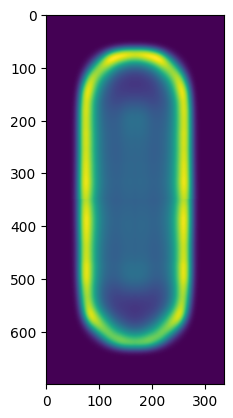

In [72]:
plt.imshow(deconv_img)

In [39]:
tifffile.imwrite("deconv_img.tiff", deconv_img)
tifffile.imwrite("img_to_deconv.tiff", img_to_deconv)
tifffile.imwrite("membrane_cell.tiff",membrane_cell)

In [40]:
deconv_profile = deconv_img[300]
conv_profile = img_to_deconv[300]
unconv_profile = membrane_cell.sum(axis=0)[300]

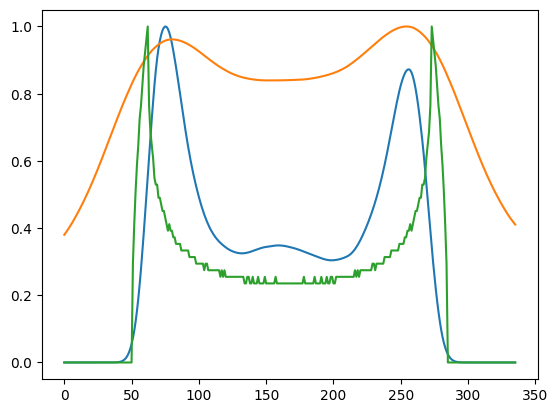

In [41]:
plt.plot(deconv_profile/deconv_profile.max())
plt.plot(conv_profile/conv_profile.max())
plt.plot(unconv_profile/unconv_profile.max())

In [58]:
2*pix_mic_conv

0.01